In [1]:
# Default parameters
Vth = 1  # spiking threshold
dt = 0.1e-3  # integration time step - s
T = 20e-3  # membrane time constant - s
N = 1000  # number of neurons in each population
K = 100  # nmber of presynaptic partners (per neuron) from each population
rX = 10  # firing rate of the Poisson neurons in population X

In [2]:
# Helper functions
import numpy as np
from numpy.random import binomial
import matplotlib.pyplot as plt
%matplotlib inline

def set_default_parameters():
    return 1, 0.1e-3, 20e-3, 1000, 100, 10

def generate_poisson_spikes(dur, num, delta = dt, rate = rX):
    return 1/dt * binomial(1, rX * delta, (num, int(dur/dt)))

def plot_spike_trains(poisson_activity, dur, ylim, delta = dt):
    spike_trains = [(delta*t, i+1) for t in range(poisson_activity.shape[1]) for i in range(poisson_activity.shape[0]) if poisson_activity[i,t]>0]

    if spike_trains != []:
        x, y = zip(*spike_trains)
        plt.scatter(x, y, marker=".", color='black')
    else:
        plt.scatter([],[]);

    plt.xlim(0, dur)
    plt.ylim(0, ylim)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Neuron")

def plot_membrane_potential(V, dur, delta=dt):
    t = np.linspace(0, dur, int(dur/delta) + 1)
    plt.plot(t, V, color='black')
    plt.xlim(0, dur)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Membrane potential")
    ax = plt.gca()
    ax.figure.set_size_inches(15, 2)

def LIF_single_input(w, Sj, dur, spike_and_reset = True, delta = dt):
    V = np.zeros(int(dur/delta) + 1)
    S_out = np.zeros(len(V))
    # Obtain V through forward Euler integration:
    if spike_and_reset:
        #  if an action potential was fired at time k-1, then set V(k-1) to 0 for the calculation of V(k)
        for k in range(1, len(V)):
            V[k] = V[k-1] + delta * (-V[k-1]/T + w * Sj[k-1])
            if V[k-1] > Vth:
                V[k] = 0
                S_out[k] = 1
    else:  # spike-and-reset mechanism has been disabled
        for k in range(1, len(V)):
            V[k] = V[k-1] + delta * (-V[k-1]/T + w * Sj[k-1])
    return S_out, V

def LIF_multiple_inputs(w, Sj, dur, spike_and_reset = True, delta = dt):
    S = np.sum(Sj, 0)
    V = np.zeros(int(dur/delta) + 1)
    S_out = np.zeros(len(V))
    # Obtain V through forward Euler integration:
    if spike_and_reset:
        #  if an action potential was fired at time k-1, then set V(k-1) to 0 for the calculation of V(k)
        for k in range(1, len(V)):
            V[k] = V[k-1] + delta * (-V[k-1]/T + w * S[k-1])
            if V[k] > Vth:
                V[k] = 0
                S_out[k] = 1

    else:  # spike-and-reset mechanism has been disabled
        for k in range(1, len(V)):
            V[k] = V[k-1] + delta * (-V[k-1]/T + w * S[k-1])
    return S_out, V

def fano(Si, window, delta = dt):
    dur = delta * len(Si)
    numWindows = int(dur / window)
    spikesInWindow = np.zeros(numWindows)
    numIndicesPerWin = int(window / delta)

    if window >= dur:
        mean = np.sum(Si)
    else:
        for i in range(numWindows):
            spikesInWindow[i] = np.sum(Si[i*numIndicesPerWin:(i+1)*numIndicesPerWin])
        mean = np.average(spikesInWindow)

    variance = np.average((spikesInWindow - mean)**2)
    print("mean is", mean)
    print("variance is", variance)
    return variance / mean

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/matplotlib/font_manager.py:229: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


### 1. Generating Poisson spike trains

Question 1 samples the activity of the X-population for 2 seconds. The activity of the X-population is modeled by a set of N independent Poisson trains. The 'firing' of each neuron is indicated by a dot in the raster plot below. At the end of question 1, the number of spikes fired by each neuron is averaged as a sanity check - the resulting value should be about 2 * rX = 20.

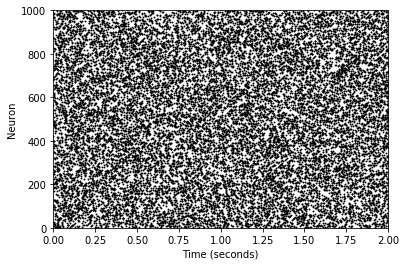

In [236]:
dur = 2.0
x_activity = generate_poisson_spikes(dur, N)
plot_spike_trains(x_activity, dur, N)

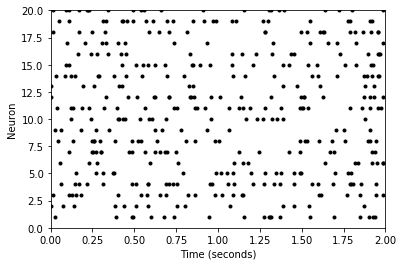

In [175]:
plot_spike_trains(x_activity, dur, 20)

In [161]:
# Sanity check: average number of spikes fired by each neuron should be about 2 * rX = 20
print("Average number of spikes fired by each neuron is ", np.average(dt*np.sum(x_activity, 1)))

Average number of spikes fired by each neuron is  19.984


### 2. Single LIF neuron with one input spike train

In question 2, the output of a leaky-integrate-and-fire neuron with one Poisson input train, is modelled. This output is shown both in terms of its membrane potential and the action potentials it fires.

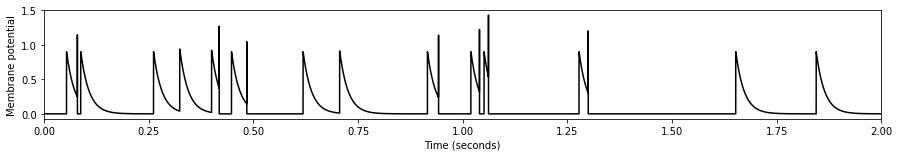

In [226]:
w = 0.9  # Synaptic weight
dur = 2.0
Sj = generate_poisson_spikes(dur, 1)[0]  # one Poisson neuron's activity

Si, V = LIF_single_input(w, Sj, dur)
#  Si = get_S_from_V(V)

plot_membrane_potential(V, dur)

Text(0, 0.5, 'Input')

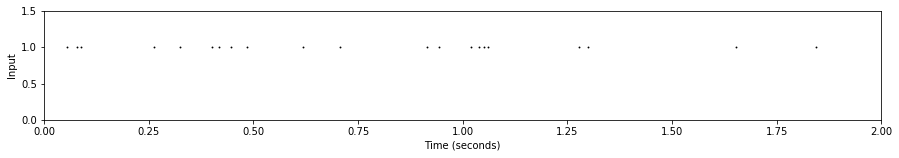

In [235]:
plot_spike_trains(np.array([Sj]), dur, 1.5)
ax = plt.gca()
ax.figure.set_size_inches(15, 2)
plt.ylabel('Input')

Text(0, 0.5, 'Output')

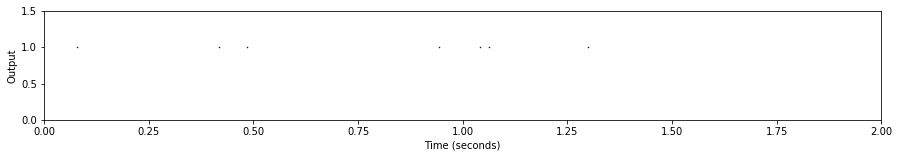

In [233]:
plot_spike_trains(np.array([Si]), dur, 1.5)
ax = plt.gca()
ax.figure.set_size_inches(15, 2)
plt.ylabel('Output')

### 3. Single LIF neuron with many input spike trains

In question 3 the output of an Lif neurone with multiple Poisson input spike trains is modeled.

(a) In this part the fluctuations in membrane potential are shown against time.

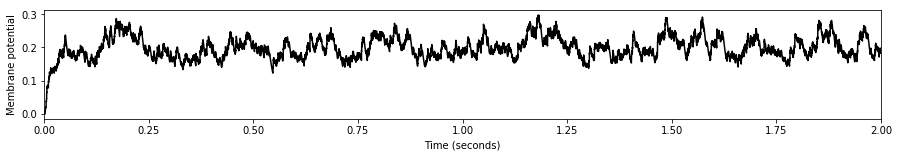

In [248]:
# S = np.sum(x_activity(0:K-1,:), 0)  # activity of K independent Poisson neurons
w = 1
dur = 2

S = generate_poisson_spikes(dur, K)
_, V = LIF_multiple_inputs(w/K, S, dur, spike_and_reset = False)

plot_membrane_potential(V, dur)

(b) Here the mean and variance of the membrane potential are derived.

Derivations:

$
E\{h\} = \frac{w}{K} * E\{\sum_{i=1}^K S_j\} = \frac{w}{K} * \sum_{i=1}^K E\{S_j\} = \frac{w}{K} * K * r_X = wr_X 
$

$
Var(h) = \frac{w}{K}^2 * Var\{\sum_{i=1}^K S_j\} = \frac{w}{K}^2 * \sum_{i=1}^K Var\{S_j\} = \frac{w}{K}^2 * K * r_X = \frac{w^2 r_X}{K}
$

Due to stationarity:

$\mu = E\{V(k)\} = E\{V(K-1)\}$

$\mu_h = E\{h(k)\} = E\{h(K-1)\}$

and variance is constant

Therefore:

$
\mu = \mu + \delta t \left[-\frac{\mu}{\tau} + \mu_h\right]
$

$
\mu = \tau \mu_h = \tau w r_X
$




Derivations for V are given in photo on phone

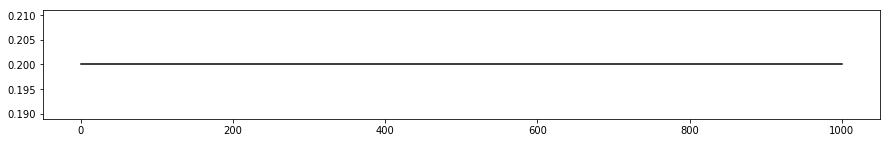

In [241]:
# (c)
m_h = w * rX
var_h = w**2 * rX / K
m_V = m_h * T
# var_V = 0
plt.plot(np.linspace(0,1000,1001), np.ones(1001)*m_V, color='black')  # plot m_V as a function of K
ax = plt.gca()
ax.figure.set_size_inches(15,2)
# plot var_V as a function of K

(d) In this part w was set to 5 to confirm theoretical predictions, that if w is set to 5 for default parameter values the mean of the membrane potential at stationarity is 1.

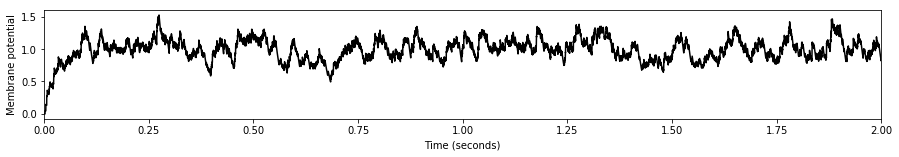

In [259]:
Vth, dt, T, N, K, rX = set_default_parameters()
w = 5
S = generate_poisson_spikes(dur, K)
_, V = LIF_multiple_inputs(w/K, S, dur, spike_and_reset = False)
plot_membrane_potential(V, dur, delta=dt)

(e) In this part the spike-and-reset mechanism is reactivated, and the value of w that makes the output firing rate c. 10 Hz is found by trial and error.

mean is 0.85
variance is 0.42749999999999994
Fano factor is 0.5029411764705882


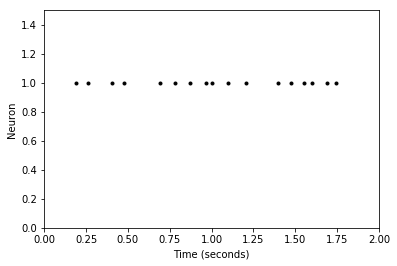

In [276]:
Vth, dt, T, N, K, rX = set_default_parameters()
w = 4.25
S = generate_poisson_spikes(dur, K)
Si, V = LIF_multiple_inputs(w/K, S, dur, spike_and_reset = True)
# S_i = get_S_from_V(V, threshold = Vth)
plot_spike_trains(np.array([Si]), dur, 1.5)
print("Fano factor is", fano(Si, 100e-3))

### 4. Single LIF neuron with many E and I Poisson inputs

Question 4 considers an LIF neuron with K excitory and K inhibitory Poisson spike train inputs.

(a)

mean is 0.8
variance is 0.6600000000000001
fano is 0.8250000000000002


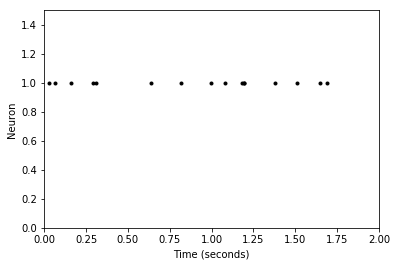

In [218]:
# {b)
w = 1.55
dur = 2.0
S_exc = generate_poisson_spikes(dur, K)  # activity of K independent excitory Poisson neurons
S_inh = -1 * generate_poisson_spikes(dur, K)  # activity of K independent inhibitory Poisson neurons
S = np.zeros((2*K, int(dur/dt)))
S[:K,:] = S_exc
S[K:2*K,:] = S_inh

Si, V = LIF_multiple_inputs(w/(K**0.5), S, dur)
# Si = get_S_from_V(V)

plot_spike_trains(np.array([Si]), dur, 1.5)
print("fano is", fano(Si, 100e-3))

### 5. Full network

In [6]:
def get_Wab(N, K, w):
    W_unshuff = np.concatenate([np.ones([N, K])*w/np.sqrt(K), np.zeros([N, N-K])], 1)
    W = np.zeros([N, N])
    for i in range(N):
        W[i, :] = np.random.permutation(W_unshuff[i,:])
    return W

def full_net(dur, tau, threshold, N, K, delta=dt, rate=rX, plot = False):
    W_EE = get_Wab(N, K, w=1.0) # second index goes to first
    W_IE = get_Wab(N, K, w=1.0) 
    W_EI = get_Wab(N, K, w=-2.0)
    W_II = get_Wab(N, K, w=-1.8)
    W_EX = get_Wab(N, K, w=1.0)
    W_IX = get_Wab(N, K, w=0.8)

    W_E_all = np.concatenate([W_EE, W_EI, W_EX], 1)
    W_I_all = np.concatenate([W_IE, W_II, W_IX], 1)

    W = np.concatenate([W_E_all, W_I_all], 0)

    trains = generate_poisson_spikes(dur, N, delta, rate)  # activity of X-population

    t = [delta * i for i in range(int(dur/dt))]

    n_steps = int(dur/dt)
    V = np.zeros([2*N, n_steps])  # membrane potential for each neuron in E and I populations
    S = np.zeros([2*N, n_steps])  # resulting action potentials from each neuron in E and I populations
    print("V.shape = {}".format(V.shape))
    print("S.shape = {}".format(S.shape))

    dVdt = np.zeros([2*N, n_steps])
    dVdt[:,0] = -V[:,0]/tau + np.matmul(W, np.concatenate([S[:,0], trains[:,0]], 0))

    for i in range(1, n_steps): # everything starts at 0
        V[:, i] = V[:,i-1] + dt * dVdt[:,i-1]
        S[:, i] = 1./dt * (V[:,i] > threshold) 
        V[:, i] = V[:,i] * (1.-(S[:,i]>0.))
        dVdt[:, i] = -V[:,i]/tau + np.matmul(W, np.concatenate([S[:,i], trains[:,i]], 0))
        if i % (n_steps/10) == 0:
            print("at t={}".format(i*dt))
    if plot:
        plt.imshow(trains)
        plt.show()
        plt.imshow(S)
        plt.show()
    return V, S, trains

In [7]:
dur = 2.0
V, S, trains = full_net(dur, T, Vth, 100, 100, dt, rX, plot = False)


V.shape = (200, 20000)
S.shape = (200, 20000)
at t=0.2
at t=0.4
at t=0.6
at t=0.8
at t=1.0
at t=1.2
at t=1.4000000000000001
at t=1.6
at t=1.8


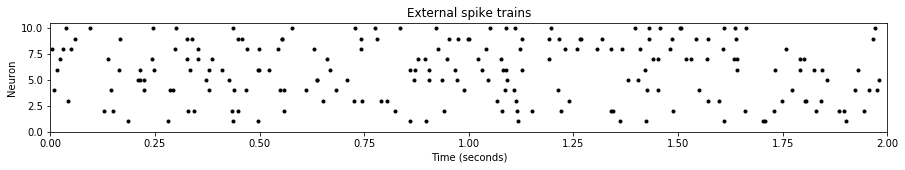

In [24]:
plot_spike_trains(trains, dur, 10.5)
plt.title("External spike trains")
ax = plt.gca()
ax.figure.set_size_inches(15,2)

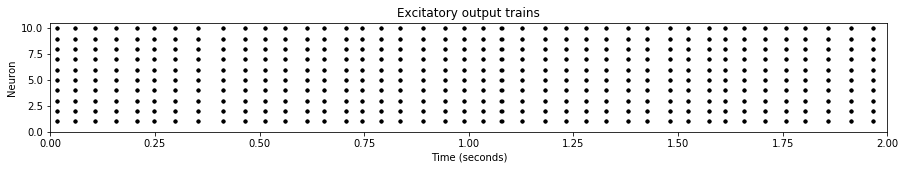

In [27]:
plot_spike_trains(S[:100,:], dur, 10.5)
plt.title("Excitatory output trains")
ax = plt.gca()
ax.figure.set_size_inches(15,2)

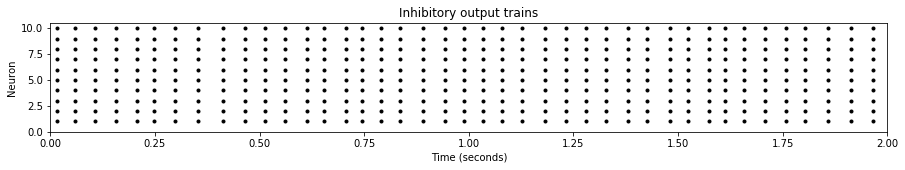

In [26]:
plot_spike_trains(S[100:,:], dur, 10.5)
plt.title("Inhibitory output trains")
ax = plt.gca()
ax.figure.set_size_inches(15,2)

In [21]:
print(N)

1000
